In [1]:
from PIL import Image
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [2]:
import numpy as np
import open3d as o3d
import random
import torch
import uuid

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import fiftyone as fo
import fiftyone.brain as fob
import fiftyone.zoo as foz
import fiftyone.utils.utils3d as fou3d
from fiftyone import ViewField as F

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [5]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [12]:
# Set a prompt to condition on.
prompt = 'Red Motor Bike'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

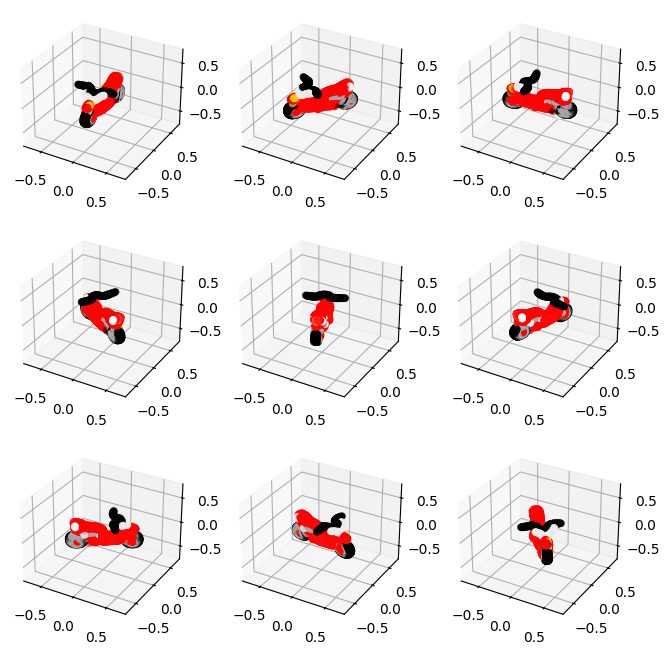

In [13]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [14]:
print(pc)
print(pc.coords.shape)
print(len(pc.channels['R']))

PointCloud(coords=array([[ 0.00308646, -0.40863067, -0.08916778],
       [-0.01859846, -0.02034299, -0.11894169],
       [ 0.00094693,  0.41634554, -0.13147731],
       ...,
       [ 0.07233218, -0.12086207, -0.1222619 ],
       [ 0.07527763, -0.04604382, -0.11048759],
       [ 0.03280426,  0.06248846, -0.14162779]], dtype=float32), channels={'R': array([0.9176471, 0.9960785, 1.       , ..., 1.       , 1.       ,
       1.       ], dtype=float32), 'G': array([0.91372555, 0.2784314 , 0.02352941, ..., 0.02745098, 0.02352941,
       0.01176471], dtype=float32), 'B': array([0.91372555, 0.2784314 , 0.02352941, ..., 0.03137255, 0.02745098,
       0.01176471], dtype=float32)})
(4096, 3)
4096


In [15]:
def generate_pcd_from_text(prompt):
    samples = None
    for x in sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt])):
        samples = x
    pointe_pcd = sampler.output_to_point_clouds(samples)[0]

    channels = pointe_pcd.channels
    r, g, b = channels["R"], channels["G"], channels["B"]
    colors = np.vstack((r, g, b)).T
    points = pointe_pcd.coords

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points)
    pcd.colors = o3d.utility.Vector3dVector(colors)
    return pcd

In [16]:
MotorBike_pcd = generate_pcd_from_text('Green motor Bike')
MotorBike_file = "MotorBike_pcd.pcd"
o3d.io.write_point_cloud(MotorBike_file, MotorBike_pcd)

True

In [17]:
Motorbike_dataset = fo.Dataset(name = 'Motorbike_dataset')
Motorbike_dataset.add_sample(
    fo.Sample(filepath=MotorBike_file)
)
session = fo.launch_app(Motorbike_dataset)